# Classifying ALE SNPs with Bitome

## Setup

### Import Required Packages

In [99]:
from pathlib import Path
import sys
import uuid

import kerastuner
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import cross_validate, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from xgboost import XGBClassifier

BITOME_KB_PATH = Path('..', 'bitome-kb')
sys.path.append(BITOME_KB_PATH.absolute().as_posix())

from bitome.core import Bitome

### Define Global Variables

In [2]:
DATA_PATH = Path('..', 'data', 'classification', 'snp')
LOCAL_CACHE_PATH = Path('..', 'local_cache')
FIG_PATH = Path('..', 'figures', 'figure_4')

### Load Pre-Prepared Bitome Knowledgebase

In [3]:
bitome = Bitome.init_from_file(Path(LOCAL_CACHE_PATH, 'bitome.pkl'))

### Prepare Feature Matrix

We want to test sum and mean for combination of features across positions, and some different scalers to deal with non-normal distributions of features

In [4]:
# load the locus tags and SNP labels for training
locus_tag_label_lookup = pd.read_csv(Path(DATA_PATH, 'train.csv'), index_col=0, squeeze=True)
y = locus_tag_label_lookup.values

# extract the sub-matrix for each locus tag
gene_sub_matrices = []
for locus_tag in locus_tag_label_lookup.index:
    
    # find the Gene object from the Bitome KB
    for g in bitome.genes:
        if g.locus_tag == locus_tag:
            gene = g
            break
            
    # pull out the relevant portion of the matrix
    location = gene.location
    gene_range = location.start.position, location.end.position
    sub_matrix = bitome.extract(column_range=gene_range).tocsc()
    
    gene_sub_matrices.append(sub_matrix)
    
# now we can sum, mean, and median across the positions
X_sum = np.array([np.asarray(sub_mat.toarray()).sum(axis=1) for sub_mat in gene_sub_matrices])
X_mean = np.array([np.asarray(sub_mat.toarray()).mean(axis=1) for sub_mat in gene_sub_matrices])
print(f'X shape: {X_sum.shape}')

X shape: (3349, 1634)


#### Feature Scaling

Let's try both MinMax and Robust scaling since we have many quite skewed features

In [5]:
min_max_scale = MinMaxScaler()
X_minmax_sum = min_max_scale.fit_transform(X_sum)
X_minmax_mean = min_max_scale.fit_transform(X_mean)

robust_scale = RobustScaler()
X_robust_sum = robust_scale.fit_transform(X_sum)
X_robust_mean = robust_scale.fit_transform(X_mean)

# prepare final X_matrices for each of our desired feature sets
X_to_try = {
    'minmax_sum': X_minmax_sum,
    'robust_sum': X_robust_sum,
    'minmax_mean': X_minmax_mean,
    'robust_mean': X_robust_mean
}

### Define Helper Functions

#### Bias/Class Weight for Neural Network

In [17]:
def bias_and_class_weight(y_train):
    # pre-compute the output bias and class weights; for imbalanced class handling
    # see https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
    total = len(y_train)
    neg, pos = np.bincount(y_train)
    initial_bias = np.log((pos / neg))
    weight_for_0 = (1 / neg) * (total / 2.0) 
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}
    return initial_bias, class_weight

#### Run Neural Network

In [11]:
def run_nn_model(model_params, X_train, y_train, X_val, y_val):
    
    # pre-compute the output bias and class weights; for imbalanced class handling
    # see https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
    initial_bias, class_weight = bias_and_class_weight(y_train)

    # instantiate the Sequential model
    model = keras.Sequential()
    
    # add the hidden layers; use the He initialization method learned from NN course 
    for layer_size, dropout_rate in zip(model_params['hidden_layer_sizes'], model_params['dropout_rates']):
        model.add(layers.Dense(
            layer_size,
            activation=model_params['activation'],
            kernel_initializer=keras.initializers.HeNormal()
        ))
        model.add(layers.Dropout(dropout_rate))
    
    # add the output layer, using the initial bias computed above
    model.add(layers.Dense(1, activation='sigmoid', bias_initializer=keras.initializers.Constant(initial_bias)))
    
    # define the metrics we'd like to use
    metrics = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.AUC(name='auc')
    ]
    
    # compile the model using typical optimizer and loss function
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    
    # define an early stopping callback to prevent continued training if validation performance stops improving
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_auc', 
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True
    )
    
    # now that we've done some computation in easier NumPy format, convert the matrices to tensors
    X_train, y_train, X_val, y_val = [tf.convert_to_tensor(mat) for mat in [X_train, y_train, X_val, y_val]]
    
    # fit the model to the training data
    model_history = model.fit(
        X_train,
        y_train,
        epochs=100,
        class_weight=class_weight,
        callbacks=[early_stopping],
        validation_data=(X_val, y_val),
        verbose=0
    )
    
    result_dict = {}
    for metric in model.metrics_names:
        result_dict[f'train_{metric}'] = model_history.history[metric][-1]
        result_dict[f'test_{metric}'] = model_history.history[f'val_{metric}'][-1]
    
    return result_dict

#### Run scikit-learn Models

In [6]:
def run_models(models_dict, X_dict, y, cv=5, file_path=None):
    """
    Runs the provided models in the models_dict with the given X matrices and targets
    
    Models_dict and X_dict have key/value pairs in the following form -> model_name: model, X_name: X_matrix
    Uses sklearn's cross_validate under the hood
    """
    
    if file_path is not None and file_path.is_file():
        print('Loaded cached result!')
        return pd.read_csv(file_path, index_col=0)

    # instantiate an empty dataframe to store our results
    full_cv_result_df = pd.DataFrame()

    for model_name, model in models_dict.items():
        print(f'{model_name}')

        for X_name, X in X_dict.items():
            print(f'{model_name}: {X_name}')
            

            # fit the provided model to the training set; use Keras specifically for the NN
            # 'model' for the nn is actually a dict of model parameters
            if type(model) == dict:
                for train_index, val_index in StratifiedKFold(n_splits=cv, shuffle=True).split(X, y):
                    # use the StratifiedKFold-provided indices to split the training set
                    X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]
                    result_row_dict = run_nn_model(model, X_train, y_train, X_val, y_val)
                    result_row_dict['model'] = model_name
                    result_row_dict['x_matrix'] = X_name
                    full_cv_result_df = full_cv_result_df.append(result_row_dict, ignore_index=True)
            else:
                
                # define the desired scoring metrics
                def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
                def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
                def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
                def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
                scoring = {
                    'tp': make_scorer(tp),
                    'tn': make_scorer(tn),
                    'fp': make_scorer(fp),
                    'fn': make_scorer(fn),
                    'auc': 'roc_auc',
                    'accuracy': 'accuracy'
                }
                
                # use stratified cross validation to assess model performance
                cv_result_df = pd.DataFrame(cross_validate(
                    model,
                    X,
                    y,
                    cv=cv,
                    scoring=scoring,
                    n_jobs=4,
                    return_train_score=True
                ))
                cv_result_df['model'] = [model_name] * cv
                cv_result_df['x_matrix'] = [X_name] * cv

                full_cv_result_df = full_cv_result_df.append(cv_result_df, ignore_index=True)
    
    # add a column that conveniently calculates the overfit difference (train - test score)
    full_cv_result_df['overfit'] = full_cv_result_df['train_auc'] - full_cv_result_df['test_auc']
    
    # save the result df so we don't have to run this initial screen again later
    if file_path is not None:
        full_cv_result_df.to_csv(file_path)
        
    return full_cv_result_df

#### Plot Model Performance

In [12]:
def plot_performance(result_df, confusion_matrix=False):
    
    if len(result_df['x_matrix'].unique()) > 1:
        hue = 'x_matrix'
    else:
        hue = None

    _, ax = plt.subplots(figsize=(10, 5))
    sns.swarmplot(x='model', y='test_auc', data=result_df, hue=hue, dodge=True, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='both', labelsize=14)
    if hue is not None:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
    ax.set_xlabel('')
    ax.set_ylabel('Val AUC', fontsize=15)

    _, ax = plt.subplots(figsize=(10, 5))
    sns.swarmplot(x='model', y='overfit', data=result_df, hue=hue, dodge=True, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='both', labelsize=14)
    if hue is not None:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
    ax.set_xlabel('')
    ax.set_ylabel('Overfit', fontsize=15)
    
    if confusion_matrix:
        
        unique_models = result_df['model'].unique()
        num_models = len(unique_models)
        if num_models == 1:
            subplot_dims, figsize = (1, 1), (4, 3)
        elif num_models == 2:
            subplot_dims, figsize = (1, 2), (8, 3)
        elif 3 <= num_models <= 4:
            subplot_dims, figsize = (2, 2), (8, 6)
        elif 5 <= num_models <= 6:
            subplot_dims, figsize = (2, 3), (12, 6)
        elif 7 <= num_models <= 8:
            subplot_dims, figsize = (2, 4), (12, 6)
        
        _, axs = plt.subplots(*subplot_dims, figsize=figsize)
        if num_models == 1:
            axs = [axs]
        else:
            axs = axs.flatten()

        for model_name, ax in zip(unique_models, axs):
            
            model_result_df = result_df[result_df['model'] == model_name]
            tn, fp, fn, tp = model_result_df[['test_tn', 'test_fp', 'test_fn', 'test_tp']].mean(axis=0)

            conf_mat = np.array([np.array([tn, fp]) / (tn + fp), np.array([fn, tp]) / (fn + tp)])

            sns.heatmap(
                conf_mat,
                cmap="PuBu",
                annot=True,
                annot_kws={'fontsize': 13},
                cbar=False,
                square=True,
                xticklabels=['No SNP', 'SNP'],
                yticklabels=['No SNP', 'SNP'],
                ax=ax
            )
            ax.tick_params(axis='both', labelsize=12)
            ax.tick_params(axis='y', rotation=0)
            ax.spines['right'].set_visible(True)
            ax.spines['left'].set_visible(True)
            ax.spines['top'].set_visible(True)
            ax.spines['bottom'].set_visible(True)
            ax.set_title(model_name)
            ax.set_xlabel('Predicted Class', fontsize=12)
            ax.set_ylabel('True Class', fontsize=12)

        if len(axs) > num_models:
            axs[-1].set_visible(False)

        plt.tight_layout()

#### Run Models and Plot

In [13]:
def run_models_and_plot_performance(
        models_dict,
        X_dict,
        y,
        cv=5,
        scoring='roc_auc',
        file_path=None,
        confusion_matrix=False
    ):
    result_df = run_models(models_dict, X_dict, y, cv=5, file_path=file_path)
    plot_performance(result_df, confusion_matrix=confusion_matrix)
    return result_df

#### Hyperoptimization

In [131]:
def hyperoptimize_nn(param_dict, X, y, n_iter=50, project_name=None):
    
    # create a train and validation split from the provided training set
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)
    
    # compute the initial bias and class weight settings (see run_nn_model for link to TF tutorial)
    initial_bias, class_weight = bias_and_class_weight(y_train)
    
    # define a build_model function, needed for Keras tuner to work properly
    # this is where we add in the parameters from the param_dict
    def build_model(hp):
        
        # construct the neural network, using the hyperparameters syntax from keras tuner
        model = keras.Sequential()
        for i in range(hp.Int('n_hidden_layers', *param_dict['n_hidden_layers'])):
            model.add(layers.Dense(
                units=hp.Int('units_' + str(i), *param_dict['hidden_layer_size']),
                activation='relu',
                kernel_initializer=keras.initializers.HeNormal(),
                kernel_regularizer=keras.regularizers.l2(hp.Float('l2', *param_dict['l2']))
            ))
            model.add(layers.Dropout(hp.Float('rate', *param_dict['dropout_rate'])))
        model.add(layers.Dense(
            1,
            activation='sigmoid',
            bias_initializer=tf.keras.initializers.Constant(initial_bias)
        ))
        
        # define the metrics to use
        metrics = [
            keras.metrics.TruePositives(name='tp'),
            keras.metrics.FalsePositives(name='fp'),
            keras.metrics.TrueNegatives(name='tn'),
            keras.metrics.FalseNegatives(name='fn'), 
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.AUC(name='auc')
        ]
        
        # compile the model using typical optimizer and loss function
        model.compile(
            optimizer=keras.optimizers.Adam(),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics
        )
        
        return model
    
    # determine the directory name to use; if this matches an existing run, that run will be
    # resumed/reloaded from the local cache
    if project_name is None:
        project_name = f'snp_hyperopt_{str(uuid.uuid4())}'

    # now we can instantiate a Keras tuner object using this build_model function
    tuner = RandomSearch(
        build_model,
        objective=kerastuner.Objective("val_auc", direction="min"),
        max_trials=n_iter,
        executions_per_trial=3,
        directory=LOCAL_CACHE_PATH,
        project_name=project_name
    )
    
    # define an early stopping callback to prevent continued training if validation performance stops improving
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_auc', 
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True
    )

    # run the hyperoptimization
    tuner.search(
        X_train,
        y_train,
        epochs=100,
        class_weight=class_weight,
        callbacks=[early_stopping],
        validation_data=(X_val, y_val),
        verbose=0
    )
    
    # access the modes and hyperparameter values from all of the trials; these are dicts
    # with hp_name: value key/value pairs
    hyperparams = [hp.values for hp in tuner.get_best_hyperparameters(num_trials=n_iter)]
    
    # access the model metrics; these are also sorted in the same order as the hyperparameters
    model_metrics = [trial.metrics.metrics for trial in tuner.oracle.get_best_trials(num_trials=n_iter)]

    # assemble the hyperparameters and results into a DataFrame 
    result_df = pd.DataFrame()
    
    for hyperparam_dict, metric_dict in zip(hyperparams, model_metrics):
        row_dict = hyperparam_dict
        
        for metric_name, metric_history in metric_dict.items():
            split_name = metric_name.split('_')
            if split_name[0] == 'val':
                new_metric_name = f'mean_test_{split_name[1]}'
            else:
                new_metric_name = f'mean_train_{split_name[0]}'
            row_dict[new_metric_name] = metric_history.get_best_value()

        result_df = result_df.append(row_dict, ignore_index=True)
    
    return result_df

In [132]:
def hyperoptimize(models_dict, X, y, n_iter=50, cv=5, file_path=None):
    """
    Given a dictionary of hyperoptimization values and models, run through a RandomizedSearchCV for each model 
    and save the raw results in a dataframe
    """
    
    # cleverly just return the results from file if the filename already exists
    if file_path is not None and file_path.is_file():
        print('Loaded cached result!')
        return pd.read_csv(file_path, index_col=0)
    
    # instantiate an empty DataFrame to which to append parameter search results
    hyperopt_result_df = pd.DataFrame()

    for model_name, model_hyperopt_dict in models_dict.items():
        print(model_name)
        
        # handle the neural network specially 
        if model_name == 'Neural Net':
            if file_path is not None:
                project_name = f'snp_{file_path.parts[-1][:-4]}'
            else:
                project_name = None
            rs_result_df = hyperoptimize_nn(model_hyperopt_dict, X, y, n_iter=n_iter, project_name=project_name)
            rs_result_df['model'] = [model_name] * rs_result_df.shape[0]
        else:
        
            # figure out if this hyperopt dict asked for a particular number of iterations
            if model_hyperopt_dict.get('n_iter', 0) > 0:
                n_iter = model_hyperopt_dict['n_iter']

            # define the desired scoring metrics
            def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
            def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
            def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
            def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
            scoring = {
                'tp': make_scorer(tp),
                'tn': make_scorer(tn),
                'fp': make_scorer(fp),
                'fn': make_scorer(fn),
                'auc': 'roc_auc',
                'accuracy': 'accuracy'
            }

            random_search_hyperopt = RandomizedSearchCV(
                model_hyperopt_dict['model'],
                model_hyperopt_dict['param_dists'],
                n_iter=n_iter,
                cv=cv,
                scoring=scoring,
                refit=False,
                n_jobs=4,
                verbose=1,
                return_train_score=True
            )

            random_search_hyperopt.fit(X, y)

            rs_result_df = pd.DataFrame(random_search_hyperopt.cv_results_)
            rs_result_df['model'] = [model_name] * rs_result_df.shape[0]
            
        hyperopt_result_df = hyperopt_result_df.append(rs_result_df)
    
    if file_path is not None:
        hyperopt_result_df.to_csv(file_path)

    return hyperopt_result_df

#### Plot Hyperoptimization Performance

In [200]:
def plot_hyperoptimization_performance(hyperopt_result_df, models_dict):
    
    # plot the overall performance of the models
    _, ax = plt.subplots()
    sns.swarmplot(x='model', y='mean_test_auc', data=hyperopt_result_df, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='both', labelsize=13)
    ax.set_xlabel('')
    ax.set_ylabel('Mean Val AUC')
    
    # for each model, identify the top 5 performing models based on the following criteria:
    # we care about both total performance and overfitting; let's define a metric that subtracts the overfit 
    # amount from the test performance; we also care about percentage breakdown of each class being classified;
    # this amounts to the fp and tp rates
    hyperopt_result_df[['tn', 'fp']] = hyperopt_result_df[['mean_test_tn', 'mean_test_fp']].divide(
        hyperopt_result_df['mean_test_tn'] + hyperopt_result_df['mean_test_fp'], axis=0
    )
    hyperopt_result_df[['fn', 'tp']] = hyperopt_result_df[['mean_test_fn', 'mean_test_tp']].divide(
        hyperopt_result_df['mean_test_fn'] + hyperopt_result_df['mean_test_tp'], axis=0
    )
    hyperopt_result_df['overfit'] = hyperopt_result_df['mean_train_auc'] - hyperopt_result_df['mean_test_auc']
    hyperopt_result_df['performance'] = hyperopt_result_df['mean_test_auc'] - hyperopt_result_df['overfit'] + (
        hyperopt_result_df[['tn', 'tp']].mean(axis=1) - hyperopt_result_df[['tn', 'tp']].std(axis=1)
    )

    num_models = len(models_dict)
    if num_models == 1:
        subplot_dims, figsize = (1, 1), (4, 3)
    elif num_models == 2:
        subplot_dims, figsize = (1, 2), (8, 3)
    elif 3 <= num_models <= 4:
        subplot_dims, figsize = (2, 2), (8, 6)
    elif 5 <= num_models <= 6:
        subplot_dims, figsize = (2, 3), (12, 6)
    elif 7 <= num_models <= 8:
        subplot_dims, figsize = (2, 4), (12, 6)

    _, axs = plt.subplots(*subplot_dims, figsize=figsize)
    if num_models == 1:
        axs = [axs]
    else:
        axs = axs.flatten()
    
    for (model_name, hyperopt_dict), ax in zip(models_dict.items(), axs):
        print(model_name)
        
        model_result_df = hyperopt_result_df[hyperopt_result_df['model'] == model_name]
        model_result_df = model_result_df.sort_values(by='performance', ascending=False)
        
        # identify the parameter columns we want to pull out
        if model_name == 'Neural Net':
            param_column_names = ['n_hidden_layers', 'units_0', 'units_1', 'units_2', 'rate', 'l2']
        else:
            param_column_names = [f'param_{param_name}' for param_name in hyperopt_dict['param_dists'].keys()]
        conf_mat_names = ['tn', 'fn', 'fp', 'tp']
            
        column_names = ['mean_train_auc', 'mean_test_auc', 'mean_test_accuracy'] + param_column_names + conf_mat_names
        
        # extract and display the desired columns for the given model
        model_result_df = model_result_df[column_names]
        display(model_result_df.iloc[:10, :])
        
        # create and display a confusion matrix for the best-performing model
        tn, fn, fp, tp = model_result_df[conf_mat_names].iloc[0, :]
        conf_mat = np.array([np.array([tn, fp]), np.array([fn, tp])])
        sns.heatmap(
            conf_mat,
            cmap="PuBu",
            annot=True,
            annot_kws={'fontsize': 13},
            cbar=False,
            square=True,
            xticklabels=['No SNP', 'SNP'],
            yticklabels=['No SNP', 'SNP'],
            ax=ax
        )
        ax.tick_params(axis='both', labelsize=12)
        ax.tick_params(axis='y', rotation=0)
        ax.spines['right'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.spines['top'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.set_title(model_name)
        ax.set_xlabel('Predicted Class', fontsize=12)
        ax.set_ylabel('True Class', fontsize=12)
        
    plt.tight_layout()

## Exploratory Analysis

### PCA

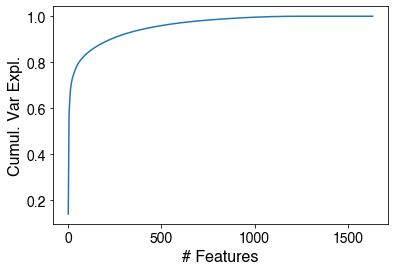

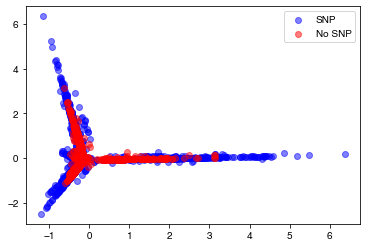

In [7]:
pca = PCA()
X_transform = pca.fit_transform(X_minmax_sum)

cum_var = np.cumsum(pca.explained_variance_ratio_)

_, ax = plt.subplots()
plt.plot(cum_var)
plt.xlabel('# Features', fontsize=16)
plt.ylabel('Cumul. Var Expl.', fontsize=16)
ax.tick_params(axis='both', labelsize=14)

pc1 = X_transform[:, 0]
pc2 = X_transform[:, 1]

_, ax = plt.subplots()

plt.scatter(pc1[y == 1], pc2[y == 1], c='blue', alpha=0.5, label='SNP')
plt.scatter(pc1[y == 0], pc2[y == 0], c='red', alpha=0.5, label='No SNP')
plt.legend()

## Model Selection

### Define Models to Try

In [7]:
models_to_try = {
    'AdaBoost': AdaBoostClassifier(),
    'Logistic Regression': LogisticRegression(
        penalty='l1',
        solver='saga',
        class_weight='balanced'
    ),
    # define this specially; see the run_nn_model function above, we are using Keras for the neural networks
    # start with a super simple model
    'Neural Net': {
        'hidden_layer_sizes': [16],
        'dropout_rates': [0.5],
        'activation': 'relu'
    },
    'Random Forest': RandomForestClassifier(
        class_weight='balanced',
        n_jobs=4
    ),
    'SVM': LinearSVC(
        penalty='l1',
        dual=False,
        class_weight='balanced'
    ),
    'XGBoost': XGBClassifier(
        n_jobs=4,
        scale_pos_weight=np.divide(*np.bincount(y))
    )
}

### Out-of-the-Box Model/Feature Normalization Evaluation

Loaded cached result!


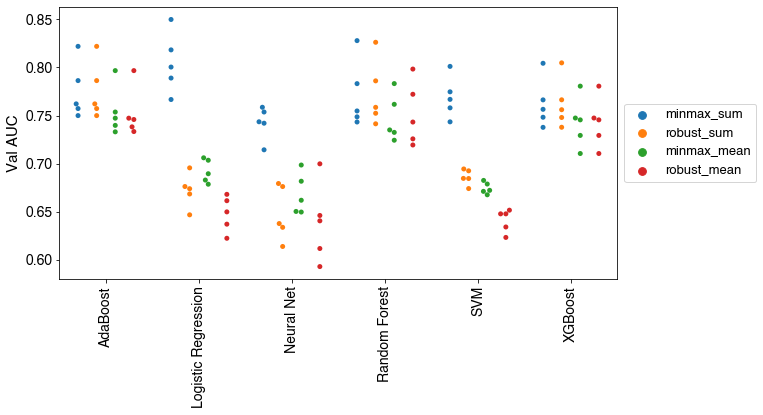

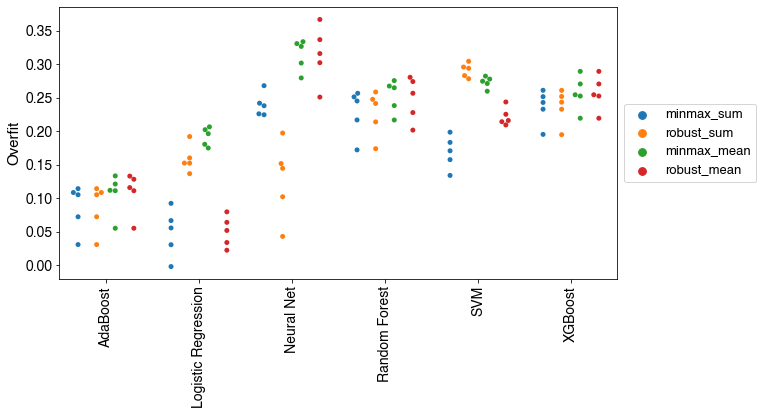

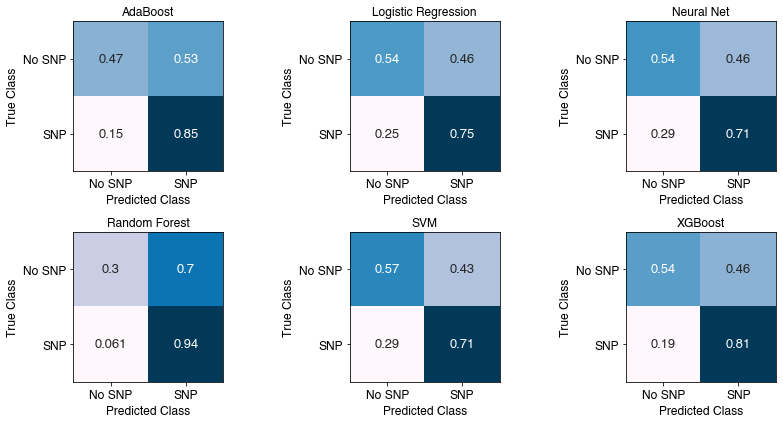

In [8]:
initial_eval_df = run_models_and_plot_performance(
    models_to_try,
    X_to_try,
    y,
    file_path=Path(DATA_PATH, 'initial_eval.csv'),
    confusion_matrix=True
)

So let's summarize these results:

- The min/max scaling seems to be the best both in terms of performance and preventing overfitting; so let's stick with it.
- None of these models is particularly balanced, but trending in the right direction (not just picking SNP all the time)

### Sequence Feature Screening

In [9]:
X_to_try_seq = {
    'bitome': X_minmax_sum,
    'seq_only': X_minmax_sum[:, :8],
    'no_seq': X_minmax_sum[:, 8:],
    'shuffled': np.random.permutation(X_minmax_sum)
}

models_to_try_seq = models_to_try

Loaded cached result!


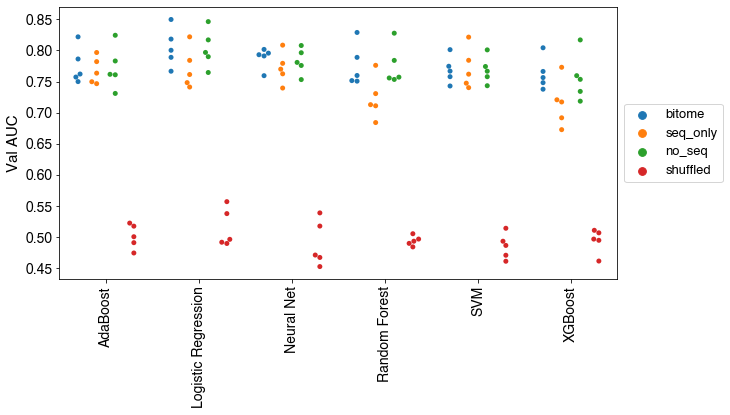

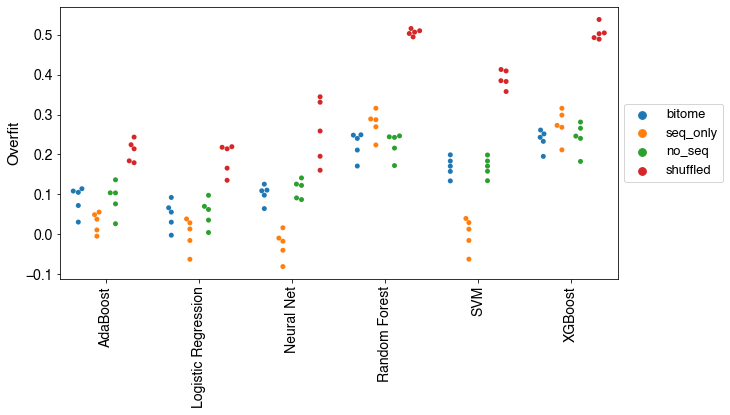

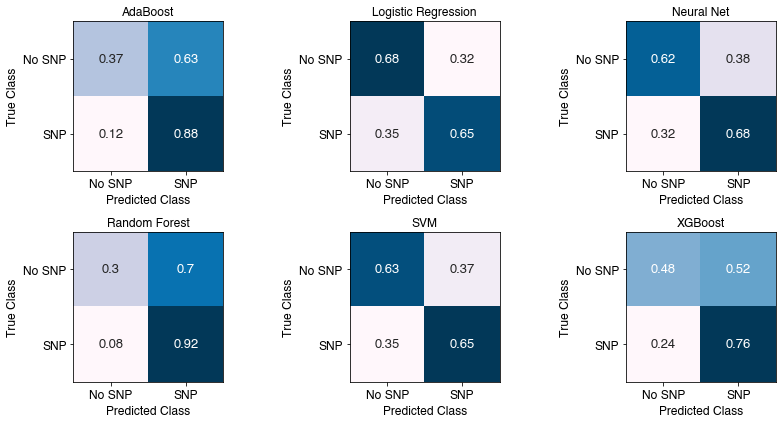

In [10]:
feature_eval_df = run_models_and_plot_performance(
    models_to_try_seq,
    X_to_try_seq,
    y,
    file_path=Path(DATA_PATH, 'feature_eval.csv'),
    confusion_matrix=True
)

Interestingly, just the sequence features seem to perform equally well at this task, and have less overfitting in many cases...

But let's stick with the full bitome feature set for now

In [14]:
X = X_minmax_sum

## Hyperparameter Optimization

Let's try some hyperparameter optimization on all of these above models

### Round 1

In [133]:
hyperopt_models_1 = {
    'AdaBoost': {
        'model': AdaBoostClassifier(),
        'param_dists': {
            'base_estimator': [DecisionTreeClassifier(max_depth=md) for md in [1, 2, 3]],
            'n_estimators': np.arange(1, 20),
            'learning_rate': np.arange(0.001, 1, 0.001)
        }
    },
    # define this specially; see the run_nn_model function above, we are using Keras for the neural networks
    # start with a super simple model
    'Neural Net': {
        'n_hidden_layers': (1, 3),
        'hidden_layer_size': (10, 100),
        'rate': (0, 1),
        'l2': (0.0001, 0.1)
    },
    'Logistic Regression': {
        'model': LogisticRegression(
            penalty='l1',
            solver='saga',
            class_weight='balanced'
        ),
        'param_dists': {
            'C': np.arange(0.01, 0.1, 0.001)
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(
            class_weight='balanced',
            n_jobs=4
        ),
        'param_dists': {
            'n_estimators': np.arange(20, 200, 5),
            'max_depth': np.arange(2, 6),
            'min_samples_split': np.arange(2, 8),
            'min_samples_leaf': np.arange(1, 5)
        }
    },
    'SVM': {
        'model': LinearSVC(
            penalty='l1',
            class_weight='balanced',
            dual=False,
            verbose=1
        ),
        'param_dists': {
            'C': np.arange(0.01, 0.1, 0.001)
        }
    },
    'XGBoost': {
        'model': XGBClassifier(
            scale_pos_weight=np.divide(*np.bincount(y)),
            n_jobs=4
        ),
        'param_dists': {
            'n_estimators': [2, 5, 10, 15, 20, 30, 40, 50],
            'learning_rate': np.arange(0.001, 1, 0.001),
            'reg_alpha': [0.0001, 0.001, 0.01, 0.1]
        },
        'n_iter': 25
    }
}

In [135]:
hyperopt_result_1_df = hyperoptimize(hyperopt_models_1, X, y, file_path=Path(DATA_PATH, 'hyperopt_1.csv'))

Loaded cached result!


AdaBoost


,mean_train_auc,mean_test_auc,mean_test_accuracy,param_base_estimator,param_n_estimators,param_learning_rate,tn,fn,fp,tp
13,0.805644,0.785583,0.753052,DecisionTreeClassifier(max_depth=1),15.0,0.778,0.537624,0.153912,0.462376,0.846088
39,0.792590,0.775599,0.746183,DecisionTreeClassifier(max_depth=1),10.0,0.769,0.540594,0.165028,0.459406,0.834972
12,0.787159,0.769511,0.741407,DecisionTreeClassifier(max_depth=1),9.0,0.742,0.541584,0.172296,0.458416,0.827704
26,0.811905,0.786623,0.753350,DecisionTreeClassifier(max_depth=1),18.0,0.757,0.535644,0.152629,0.464356,0.847371
23,0.823063,0.791046,0.754844,DecisionTreeClassifier(max_depth=2),8.0,0.801,0.528713,0.147499,0.471287,0.852501
15,0.790306,0.763175,0.744691,DecisionTreeClassifier(max_depth=1),11.0,0.976,0.542574,0.168021,0.457426,0.831979
10,0.771269,0.750563,0.737824,DecisionTreeClassifier(max_depth=1),7.0,0.963,0.543564,0.178281,0.456436,0.821719
6,0.814272,0.779750,0.753349,DecisionTreeClassifier(max_depth=1),18.0,0.946,0.531683,0.150919,0.468317,0.849081
28,0.750100,0.736128,0.730061,DecisionTreeClassifier(max_depth=1),3.0,0.876,0.538614,0.187260,0.461386,0.812740
40,0.829385,0.784678,0.753351,DecisionTreeClassifier(max_depth=2),10.0,0.843,0.529703,0.150064,0.470297,0.849936


Neural Net


,mean_train_auc,mean_test_auc,mean_test_accuracy,n_hidden_layers,units_0,units_1,units_2,rate,l2,tn,fn,fp,tp
49,0.531579,0.751225,0.572139,3.0,11.0,97.0,94.0,0.158305,0.044593,0.816964,0.186370,0.183036,0.813630
38,0.576989,0.725463,0.570149,2.0,67.0,68.0,28.0,0.026326,0.077584,0.707113,0.168200,0.292887,0.831800
47,0.633520,0.749864,0.637313,2.0,97.0,79.0,64.0,0.011180,0.006635,0.782796,0.299206,0.217204,0.700794
46,0.561456,0.742285,0.593532,2.0,93.0,55.0,72.0,0.153470,0.046520,0.529412,0.087017,0.470588,0.912983
39,0.544841,0.726494,0.565174,2.0,94.0,84.0,87.0,0.241740,0.073610,0.412371,0.037705,0.587629,0.962295
29,0.567058,0.688276,0.591542,1.0,92.0,40.0,87.0,0.137179,0.051812,0.341772,0.103713,0.658228,0.896287
48,0.541037,0.750767,0.606468,2.0,85.0,93.0,80.0,0.377018,0.035594,0.188889,0.017021,0.811111,0.982979
36,0.540232,0.723335,0.582587,2.0,57.0,70.0,37.0,0.352138,0.035273,0.191919,0.016768,0.808081,0.983232
37,0.567112,0.724613,0.613433,2.0,98.0,12.0,73.0,0.277218,0.020518,0.175573,0.045977,0.824427,0.954023
43,0.555379,0.738888,0.562189,2.0,40.0,37.0,34.0,0.026435,0.074125,0.079365,0.003425,0.920635,0.996575


Logistic Regression


,mean_train_auc,mean_test_auc,mean_test_accuracy,param_C,tn,fn,fp,tp
26,0.786496,0.782542,0.681692,0.100,0.754455,0.349722,0.245545,0.650278
6,0.785465,0.781455,0.681393,0.098,0.753465,0.349722,0.246535,0.650278
11,0.785974,0.781965,0.681393,0.099,0.754455,0.350150,0.245545,0.649850
25,0.784953,0.780956,0.679602,0.097,0.753465,0.352287,0.246535,0.647713
29,0.783915,0.780024,0.679602,0.095,0.754455,0.352715,0.245545,0.647285
39,0.782295,0.778685,0.679004,0.092,0.753465,0.353142,0.246535,0.646858
22,0.783380,0.779550,0.678706,0.094,0.754455,0.353997,0.245545,0.646003
45,0.782833,0.779106,0.678407,0.093,0.753465,0.353997,0.246535,0.646003
2,0.780704,0.777297,0.677212,0.089,0.751485,0.354853,0.248515,0.645147
40,0.778183,0.775247,0.675122,0.084,0.748515,0.356563,0.251485,0.643437


Random Forest


,mean_train_auc,mean_test_auc,mean_test_accuracy,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,tn,fn,fp,tp
8,0.789493,0.767144,0.689153,175.0,2.0,7.0,3.0,0.691089,0.311672,0.308911,0.688328
40,0.789399,0.766455,0.690648,195.0,2.0,5.0,4.0,0.688119,0.308251,0.311881,0.691749
21,0.799019,0.769285,0.693037,110.0,3.0,2.0,3.0,0.696040,0.308251,0.303960,0.691749
31,0.787595,0.765473,0.692440,60.0,2.0,6.0,4.0,0.688119,0.305686,0.311881,0.694314
34,0.805288,0.772731,0.690346,45.0,4.0,5.0,3.0,0.692079,0.310389,0.307921,0.689611
9,0.808862,0.772821,0.695724,195.0,4.0,5.0,3.0,0.693069,0.303121,0.306931,0.696879
38,0.797507,0.770202,0.690052,65.0,3.0,7.0,3.0,0.697030,0.312954,0.302970,0.687046
49,0.809999,0.773062,0.691245,195.0,4.0,7.0,1.0,0.691089,0.308679,0.308911,0.691321
3,0.796465,0.767466,0.690946,35.0,3.0,2.0,3.0,0.694059,0.310389,0.305941,0.689611
25,0.807129,0.772283,0.696620,150.0,4.0,4.0,4.0,0.691089,0.300983,0.308911,0.699017


SVM


,mean_train_auc,mean_test_auc,mean_test_accuracy,param_C,tn,fn,fp,tp
33,0.819481,0.807359,0.704979,0.096,0.774257,0.324925,0.225743,0.675075
49,0.818943,0.807274,0.704979,0.094,0.775248,0.325353,0.224752,0.674647
17,0.819740,0.807378,0.705278,0.097,0.775248,0.324925,0.224752,0.675075
27,0.820024,0.807389,0.704382,0.098,0.774257,0.325780,0.225743,0.674220
7,0.818684,0.807224,0.704083,0.093,0.775248,0.326635,0.224752,0.673365
26,0.820554,0.807399,0.704084,0.100,0.773267,0.325780,0.226733,0.674220
46,0.816956,0.806896,0.703784,0.086,0.776238,0.327490,0.223762,0.672510
15,0.820292,0.807406,0.703785,0.099,0.773267,0.326208,0.226733,0.673792
32,0.811848,0.804855,0.701397,0.067,0.772277,0.329201,0.227723,0.670799
25,0.817707,0.807001,0.704382,0.089,0.777228,0.327063,0.222772,0.672937


XGBoost


,mean_train_auc,mean_test_auc,mean_test_accuracy,param_n_estimators,param_learning_rate,param_reg_alpha,tn,fn,fp,tp
7,0.855775,0.766081,0.707968,2.0,0.464,0.0001,0.683168,0.281317,0.316832,0.718683
16,0.865269,0.771566,0.708861,5.0,0.117,0.0001,0.680198,0.278752,0.319802,0.721248
15,0.898963,0.783899,0.718117,10.0,0.251,0.1000,0.688119,0.268918,0.311881,0.731082
22,0.848763,0.760936,0.700505,50.0,0.002,0.0001,0.677228,0.289440,0.322772,0.710560
20,0.899906,0.786572,0.718416,20.0,0.118,0.0100,0.680198,0.265071,0.319802,0.734929
1,0.896772,0.782207,0.713937,10.0,0.245,0.0100,0.683168,0.272766,0.316832,0.727234
14,0.875752,0.772519,0.712146,5.0,0.238,0.0001,0.680198,0.274049,0.319802,0.725951
10,0.896149,0.781379,0.711847,10.0,0.236,0.0100,0.680198,0.274476,0.319802,0.725524
12,0.853148,0.762220,0.700503,5.0,0.039,0.0100,0.669307,0.286020,0.330693,0.713980
4,0.903691,0.786186,0.712742,15.0,0.189,0.0010,0.672277,0.269773,0.327723,0.730227


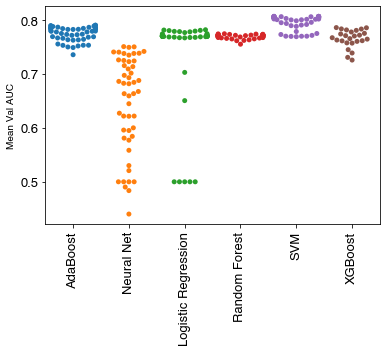

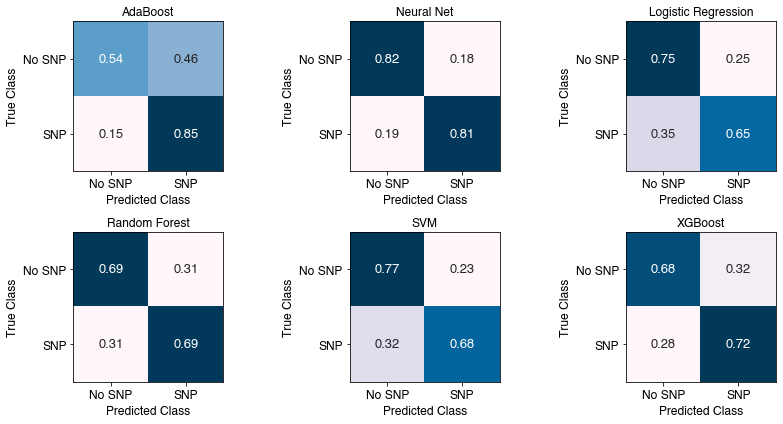

In [201]:
plot_hyperoptimization_performance(hyperopt_result_1_df, hyperopt_models_1)

#### Round 1 Analysis

AdaBoost performs very well in both AUC and accuracy; but it is picking the majority class in a biased way. 

The neural networks are heavily biased to pick the majority class. 



#### Logistic Regression [DONE]

In [15]:
hyperopt_result_df_1[
    hyperopt_result_df_1['model'] == 'LR'
].sort_values(by='mean_test_score', ascending=False)[['params', 'mean_test_score', 'mean_train_score']].head()

,params,mean_test_score,mean_train_score
22,{'C': 0.496},0.807787,0.827286
10,{'C': 0.454},0.807708,0.824686
13,{'C': 0.51},0.807704,0.828138
5,{'C': 0.41600000000000004},0.807691,0.822247
21,{'C': 0.429},0.807668,0.823085


Okay so let's call LR done. C=0.45 seems good (a touch less overfitting), and the full bitome features are slightly better

#### Linear SVM [DONE]

In [17]:
hyperopt_result_df_1[
    hyperopt_result_df_1['model'] == 'Linear SVM'
].sort_values(by='mean_test_score', ascending=False)[['params', 'mean_test_score', 'mean_train_score']].iloc[:10, :]

,params,mean_test_score,mean_train_score
21,{'C': 0.129},0.807344,0.827990
24,{'C': 0.162},0.805781,0.836397
14,{'C': 0.07200000000000001},0.805604,0.813093
23,{'C': 0.189},0.804780,0.842913
6,{'C': 0.191},0.804694,0.843367
22,{'C': 0.196},0.804435,0.844470
17,{'C': 0.21},0.803661,0.847568
20,{'C': 0.215},0.803356,0.848687
18,{'C': 0.247},0.801177,0.855911
1,{'C': 0.364},0.794231,0.880744


For Linear SVM, C=0.07 looks like a great choice, reduced overfitting. Again, the full bitome features are pretty much strictly better, so let's stick with those and call this done.

#### RBF SVM [DONE]

In [18]:
hyperopt_result_df_1[
    hyperopt_result_df_1['model'] == 'RBF SVM'
].sort_values(by='mean_test_score', ascending=False)[['params', 'mean_test_score', 'mean_train_score']].iloc[:10, :]

,params,mean_test_score,mean_train_score
20,"{'kernel': 'rbf', 'C': 0.501}",0.797601,0.866880
8,"{'kernel': 'rbf', 'C': 0.6950000000000001}",0.796801,0.882828
12,"{'kernel': 'rbf', 'C': 0.335}",0.796312,0.849773
13,"{'kernel': 'rbf', 'C': 0.788}",0.796224,0.889573
3,"{'kernel': 'rbf', 'C': 0.889}",0.795422,0.896118
19,"{'kernel': 'rbf', 'C': 0.9440000000000001}",0.795050,0.899665
10,"{'kernel': 'rbf', 'C': 0.121}",0.789759,0.814770
24,"{'kernel': 'poly', 'C': 0.551}",0.788036,0.883091
0,"{'kernel': 'poly', 'C': 0.557}",0.787968,0.883619
6,"{'kernel': 'poly', 'C': 0.446}",0.787902,0.872521


Here, index 10 (the RBF kernel with C=0.121 looks great and isn't too overfit. Let's use that in the final model.

#### Random Forest

In [19]:
hyperopt_result_df_1[
    hyperopt_result_df_1['model'] == 'RF'
].sort_values(by='mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_train_score', 'param_n_estimators', 'param_max_depth'
]].head()

,mean_test_score,mean_train_score,param_n_estimators,param_max_depth
13,0.777169,0.876049,230.0,8.0
12,0.777119,0.897480,460.0,9.0
5,0.776981,0.897525,490.0,9.0
9,0.776303,0.877065,480.0,8.0
2,0.776231,0.856728,130.0,7.0


Okay we have some overfitting with these models; let's re-sort the hyperopt results to highlight the models with the least overfitting (difference between train and test score) since the test scores are quite consistent.

In [20]:
rf_hyperopt_df = hyperopt_result_df_1[hyperopt_result_df_1['model'] == 'RF']
rf_hyperopt_df['overfit'] = rf_hyperopt_df['mean_train_score'] - rf_hyperopt_df['mean_test_score']
rf_hyperopt_df = rf_hyperopt_df.sort_values(by='overfit')
rf_hyperopt_df[['mean_test_score', 'mean_train_score', 'param_n_estimators', 'param_max_depth']].iloc[:10, :]

/Users/cam/.virtualenvs/bitome/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,mean_test_score,mean_train_score,param_n_estimators,param_max_depth
7,0.770627,0.796932,120.0,4.0
5,0.770078,0.797325,420.0,4.0
12,0.769772,0.797555,350.0,4.0
0,0.770367,0.799928,340.0,3.0
22,0.769552,0.799634,250.0,3.0
3,0.769359,0.800127,490.0,3.0
19,0.768669,0.799766,270.0,3.0
16,0.772117,0.810425,130.0,4.0
24,0.772472,0.810798,320.0,4.0
20,0.772340,0.810686,310.0,4.0


Okay, so keeping max_depth low is key to prevent overfitting. Let's do one more round and try keeping max depth at 5 or lower, and test if we can get any better performance tweaking other parameters. Again, the full bitome features are better.

#### Neural Network

In [22]:
hyperopt_result_df_1[
    hyperopt_result_df_1['model'] == 'NN'
].sort_values(by='mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_train_score', 'param_hidden_layer_sizes'
]]

,mean_test_score,mean_train_score,param_hidden_layer_sizes
11,0.796532,0.842142,"(160, 199, 105, 98)"
16,0.796188,0.836500,"(76, 72, 196, 119)"
5,0.795705,0.838838,"(106, 238)"
23,0.795416,0.832491,"(175, 148, 57)"
19,0.795375,0.856845,"(148, 155)"
2,0.795086,0.859406,"(104, 144)"
1,0.795020,0.861770,"(106, 55)"
14,0.794796,0.839556,"(147, 123, 150)"
10,0.794454,0.832827,"(201, 104, 143)"
22,0.794436,0.847707,"(119, 249)"


A 2-layer net shows up and seems to do fine, so let's see if we can tune that in further.

#### AdaBoost

In [29]:
hyperopt_result_df_1[
    hyperopt_result_df_1['model'] == 'AdaBoost'
].sort_values(by='mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_train_score', 'param_n_estimators', 'param_learning_rate', 'param_base_estimator'
]].iloc[:10, :]

,mean_test_score,mean_train_score,param_n_estimators,param_learning_rate,param_base_estimator
23,0.787816,0.873390,50.0,0.13,DecisionTreeClassifier(max_depth=2)
13,0.783749,0.804864,5.0,0.64,DecisionTreeClassifier(max_depth=2)
21,0.777949,0.910747,50.0,0.30,DecisionTreeClassifier(max_depth=2)
19,0.770752,0.878824,25.0,0.60,DecisionTreeClassifier(max_depth=2)
7,0.763052,0.837725,35.0,0.14,DecisionTreeClassifier(max_depth=3)
0,0.758632,0.990522,90.0,0.04,DecisionTreeClassifier(max_depth=5)
8,0.749011,0.900469,30.0,0.98,DecisionTreeClassifier(max_depth=2)
1,0.748038,0.863911,60.0,0.13,DecisionTreeClassifier(max_depth=3)
20,0.745647,1.000000,90.0,0.65,DecisionTreeClassifier(max_depth=9)
2,0.745309,0.999964,70.0,0.15,DecisionTreeClassifier(max_depth=5)


The 5 estimators is pretty nice! Let's explore small numbers of trees with different learning rates. And let's keep the base estimator's max depth 5 or lower.

#### XGBoost

In [30]:
hyperopt_result_df_1[
    hyperopt_result_df_1['model'] == 'XGBoost'
].sort_values(by='mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_train_score', 'param_n_estimators', 'param_learning_rate'
]].iloc[:10, :]

,mean_test_score,mean_train_score,param_n_estimators,param_learning_rate
7,0.792876,0.912846,50.0,0.100
8,0.788358,0.957155,100.0,0.100
6,0.786958,0.884385,25.0,0.100
5,0.774625,0.858408,100.0,0.010
4,0.772633,0.845330,50.0,0.010
3,0.767540,0.832870,25.0,0.010
2,0.762270,0.820707,100.0,0.001
5,0.762018,0.818888,100.0,0.010
6,0.760676,0.836541,25.0,0.100
4,0.760597,0.810391,50.0,0.010


Less overfitting with lower learning rate, but also lower performance; maybe we can reduce overfitting with fewer eestimators but the higher two learning rates. Try that

### Round 2

We've learned about where to refine our hyperoptimization searches (see above views at good parameters)

Here's the Round 2 rundown:
- Logistic Regression, Linear and RBF SVM are finalists and have been optimized to the extent possible with regularization (the 'C' parameter)
- The remainder can be further optimized

In [32]:
hyperopt_models_2 = {
    'RF': {
        'model': RandomForestClassifier(
            class_weight='balanced',
            verbose=1
        ),
        # add in a new parameter to see if that makes a difference
        'param_dists': {
            'criterion': ['gini', 'entropy'],
            'n_estimators': np.arange(25, 250, 5),
            'max_depth': np.arange(3, 6),
            'min_samples_split': np.arange(2, 6),
            'min_samples_leaf': np.arange(1, 6)
        }
    },
    'NN': {
        'model': MLPClassifier(
            solver='adam',
            activation='relu',
            learning_rate='adaptive',
            early_stopping=True,
            validation_fraction=0.2,
            n_iter_no_change=5,
            verbose=1
        ),
        'param_dists': {
            'hidden_layer_sizes': hidden_layer_sizes,
            'alpha': [0.01, 0.001, 0.0001]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(),
        'param_dists': {
            'base_estimator': [DecisionTreeClassifier(max_depth=md) for md in np.arange(2, 6)],
            'n_estimators': np.arange(5, 25),
            'learning_rate': np.arange(0.1, 0.7, 0.01)
        }
    },
    'XGBoost': {
        'model': XGBClassifier(
            max_depth=5,
            verbose=1
        ),
        'param_dists': {
            'n_estimators': np.arange(5, 50),
            'learning_rate': [0.01, 0.1]
        }
    }
}

In [35]:
hyperopt_result_df_2 = hyperoptimize({'bitome': X_minmax_sum}, y, hyperopt_models_2, 'hyperopt_snp_2')

Loaded cached result!


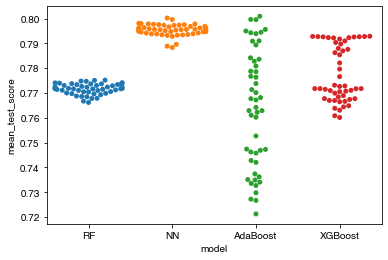

In [36]:
sns.swarmplot(x='model', y='mean_test_score', data=hyperopt_result_df_2)

#### Random Forest [DONE]

In [38]:
hyperopt_result_df_2[
    hyperopt_result_df_2['model'] == 'RF'
].sort_values(by='mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_train_score', 'param_n_estimators', 'param_max_depth', 'param_criterion',
    'param_min_samples_split', 'param_min_samples_leaf'
]].iloc[:10, :]

,mean_test_score,mean_train_score,param_n_estimators,param_max_depth,param_criterion,param_min_samples_split,param_min_samples_leaf
38,0.775154,0.816969,190.0,5.0,entropy,5.0,2.0
40,0.775069,0.823214,200.0,5.0,gini,3.0,1.0
0,0.774790,0.818757,230.0,5.0,entropy,5.0,1.0
14,0.774701,0.806403,205.0,4.0,entropy,5.0,4.0
36,0.774081,0.813815,215.0,5.0,entropy,5.0,5.0
6,0.774048,0.816843,95.0,5.0,entropy,5.0,2.0
41,0.773994,0.819868,220.0,5.0,gini,5.0,3.0
30,0.773947,0.814559,145.0,5.0,entropy,2.0,4.0
2,0.773751,0.816706,150.0,5.0,gini,5.0,5.0
18,0.773670,0.822091,115.0,5.0,gini,5.0,1.0


Let's go with n_estimators 100, max_depth of 5, criterion doesn't seem to matter, min_samples_split of 5, min_samples_leaf of 2.

#### Neural Network [DONE]

In [39]:
hyperopt_result_df_2[
    hyperopt_result_df_2['model'] == 'NN'
].sort_values(by='mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_train_score', 'param_hidden_layer_sizes', 'param_alpha'
]].head()

,mean_test_score,mean_train_score,param_hidden_layer_sizes,param_alpha
3,0.800196,0.850777,"(136, 234)",0.0100
4,0.799574,0.844755,"(235, 145)",0.0001
13,0.798029,0.857250,"(199, 60)",0.0010
41,0.797947,0.854672,"(158, 152)",0.0001
30,0.797841,0.848344,"(129, 220)",0.0010


Some overfitting in most of these, so let's add that 'overfit' column (as with RF in Round 1)

In [40]:
nn_hyperopt_df = hyperopt_result_df_2[hyperopt_result_df_2['model'] == 'NN']
nn_hyperopt_df['overfit'] = nn_hyperopt_df['mean_train_score'] - nn_hyperopt_df['mean_test_score']
nn_hyperopt_df = nn_hyperopt_df.sort_values(by='overfit')
nn_hyperopt_df[['mean_test_score', 'mean_train_score', 'param_hidden_layer_sizes', 'param_alpha']].iloc[:10, :]

/Users/cam/.virtualenvs/bitome/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,mean_test_score,mean_train_score,param_hidden_layer_sizes,param_alpha
11,0.793835,0.833251,"(63, 56)",0.0001
42,0.795483,0.835864,"(158, 152)",0.0010
33,0.796210,0.837387,"(231, 228)",0.0100
31,0.795592,0.837120,"(71, 227)",0.0001
35,0.796058,0.838098,"(218, 155)",0.0001
14,0.793565,0.836813,"(245, 114)",0.0100
18,0.793383,0.838046,"(184, 171)",0.0001
7,0.795743,0.840534,"(76, 132)",0.0100
38,0.794684,0.839829,"(243, 95)",0.0100
4,0.799574,0.844755,"(235, 145)",0.0001


So let's call it and go with 100, 100 for the hidden layers, and alpha of 0.001. 

#### AdaBoost [DONE]

In [43]:
hyperopt_result_df_2[
    hyperopt_result_df_2['model'] == 'AdaBoost'
].sort_values(by='mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_train_score', 'param_base_estimator', 'param_learning_rate', 'param_n_estimators'
]].head()

,mean_test_score,mean_train_score,param_base_estimator,param_learning_rate,param_n_estimators
43,0.800915,0.818296,DecisionTreeClassifier(max_depth=2),0.36,8.0
20,0.799630,0.826418,DecisionTreeClassifier(max_depth=2),0.26,12.0
30,0.799549,0.835103,DecisionTreeClassifier(max_depth=2),0.33,14.0
2,0.795600,0.843085,DecisionTreeClassifier(max_depth=3),0.34,8.0
47,0.794967,0.819463,DecisionTreeClassifier(max_depth=2),0.10,20.0


Well that top model is great, let's use it straight up!

#### XGBoost

In [45]:
hyperopt_result_df_2[
    hyperopt_result_df_2['model'] == 'XGBoost'
].sort_values(by='mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_train_score', 'param_n_estimators', 'param_learning_rate'
]].head()

,mean_test_score,mean_train_score,param_n_estimators,param_learning_rate
26,0.792854,0.897000,36.0,0.1
3,0.792767,0.901020,39.0,0.1
38,0.792755,0.901913,40.0,0.1
12,0.792713,0.899453,38.0,0.1
29,0.792668,0.898205,37.0,0.1


Overfitting; let's see what parameters reduced that

In [47]:
xg_hyperopt2_df = hyperopt_result_df_2[hyperopt_result_df_2['model'] == 'XGBoost']
xg_hyperopt2_df['overfit'] = xg_hyperopt2_df['mean_train_score'] - nn_hyperopt_df['mean_test_score']
xg_hyperopt2_df = xg_hyperopt2_df.sort_values(by='overfit')
xg_hyperopt2_df[['mean_test_score', 'mean_train_score', 'param_n_estimators', 'param_learning_rate']].iloc[:10, :]

/Users/cam/.virtualenvs/bitome/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,mean_test_score,mean_train_score,param_n_estimators,param_learning_rate
32,0.760107,0.814296,6.0,0.01
28,0.760815,0.816074,7.0,0.01
14,0.763047,0.820413,10.0,0.01
33,0.764393,0.824096,14.0,0.01
8,0.764847,0.822824,13.0,0.01
23,0.763816,0.824577,15.0,0.01
41,0.766598,0.829077,18.0,0.01
17,0.766956,0.830794,21.0,0.01
46,0.767685,0.834408,27.0,0.01
39,0.766449,0.830064,19.0,0.01


So let's try keeping estimators under 50 and learning rate at 0.01. Let's add in L1 regularization as well.

### Round 3

In [50]:
hyperopt_models_3 = {
    'XGBoost': {
        'model': XGBClassifier(
            max_depth=5,
            learning_rate=0.01,
            verbose=1
        ),
        'param_dists': {
            'n_estimators': np.arange(2, 40, 4),
            'reg_alpha': np.arange(0.001, 1, 0.001)
        }
    }
}

In [53]:
hyperopt_result_df_3 = hyperoptimize({'bitome': X_minmax_sum}, y, hyperopt_models_3, 'hyperopt_snp_3', n_iter=20)

Loaded cached result!


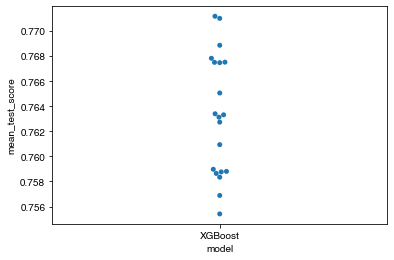

In [54]:
sns.swarmplot(x='model', y='mean_test_score', data=hyperopt_result_df_3)

#### XGBoost [DONE]

In [55]:
hyperopt_result_df_3[
    hyperopt_result_df_3['model'] == 'XGBoost'
].sort_values(by='mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_train_score', 'param_n_estimators', 'param_reg_alpha'
]]

,mean_test_score,mean_train_score,param_n_estimators,param_reg_alpha
4,0.771181,0.839853,38,0.214
14,0.771012,0.839880,38,0.282
19,0.768865,0.835643,30,0.399
6,0.767827,0.835447,30,0.088
12,0.767519,0.833728,30,0.939
3,0.767504,0.835364,30,0.189
5,0.767478,0.835964,30,0.022
1,0.765060,0.830864,26,0.902
8,0.763401,0.824262,18,0.507
16,0.763318,0.826265,22,0.787


So that top model looks good, perhaps a reg_alpha of 0.25 along with 50 estimators for final model.

## Final Model

Let's define the parameters for our best models that we discovered in hyperoptimization

In [12]:
best_models = {
    'LR': LogisticRegression(
        penalty='l1',
        C=0.045,
        solver='saga',
        class_weight='balanced',
        verbose=1
    ),
    'Linear SVM': SVC(
        probability=True,
        kernel='linear',
        C=0.07,
        class_weight='balanced',
        verbose=1
    ),
    'RBF SVM': SVC(
        probability=True,
        kernel='rbf',
        C=0.121,
        class_weight='balanced'
    ),
    'RF': RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        verbose=1
    ),
    'NN': MLPClassifier(
        hidden_layer_sizes=(100, 100),
        alpha=0.001,
        solver='adam',
        activation='relu',
        learning_rate='adaptive',
        early_stopping=True,
        validation_fraction=0.2,
        n_iter_no_change=5,
        verbose=1
    ),
    'AdaBoost': AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=2),
        n_estimators=8,
        learning_rate=0.36
    ),
    'XGBoost': XGBClassifier(
        n_estimators=50,
        max_depth=5,
        learning_rate=0.01,
        reg_alpha=0.25,
        verbose=1
    )
}

In [ ]:
final_result_df = pd.DataFrame(
    columns=['model', 'train_auc', 'test_auc']
)

N_CV = 5

for model_name, model in best_models.items():
    print(f'{model_name}')
        
    cv_result = cross_validate(
        model,
        X_minmax_sum,
        y=y,
        cv=N_CV,
        scoring='roc_auc',
        return_train_score=True,
        verbose=1,
        n_jobs=4
    )

    sub_result_df = pd.DataFrame(
        data={
            'model': [model_name] * N_CV,
            'train_auc': cv_result['train_score'],
            'test_auc': cv_result['test_score']
        }
    )

    final_result_df = final_result_df.append(sub_result_df)

In [62]:
final_result_df.to_csv(Path(DATA_PATH, 'final_performance.csv'))

Text(0, 0.5, 'AUC')

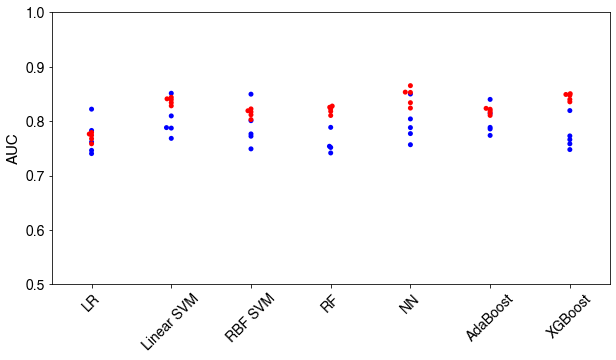

In [36]:
final_result_df = pd.read_csv(Path(DATA_PATH, 'final_performance.csv'), index_col=0)

_, ax = plt.subplots(figsize=(10, 5))
sns.swarmplot(x='model', y='test_auc', data=final_result_df, color='b', label='Val', dodge=True, ax=ax)
sns.swarmplot(x='model', y='train_auc', data=final_result_df, color='r', label='Train', dodge=True, ax=ax)
ax.set_ylim(0.5, 1)
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel('')
ax.set_ylabel('AUC', fontsize=15)

### Performance Breakdown

How are these modes achieving this score? Guessing each class equally? Let's look at confusion matrices

In [54]:
X_perf_train, X_perf_val, y_perf_train, y_perf_val = train_test_split(X_minmax_sum, y, test_size=0.25, stratify=y)

In [ ]:
val_y_pred_df = pd.DataFrame()

for model_name, model in best_models.items():
    model.fit(X_perf_train, y_perf_train)
    y_perf_pred = model.predict(X_perf_val)
    val_y_pred_df[model_name] = y_perf_pred
    
val_y_pred_df.to_csv(Path(DATA_PATH, 'val_predictions.csv'))

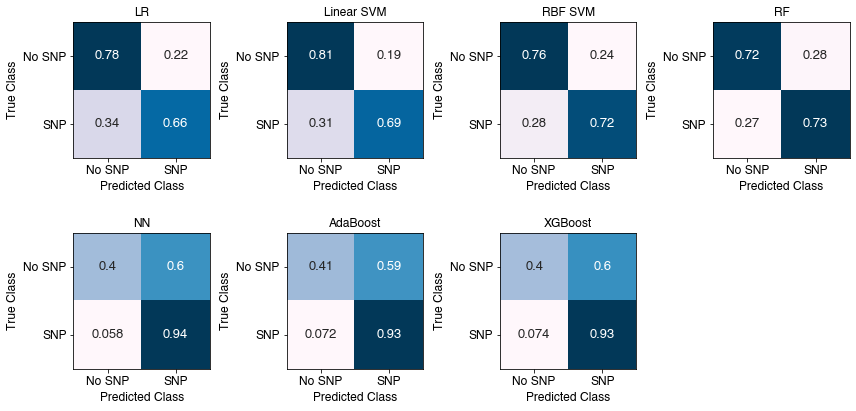

In [60]:
val_y_pred_df = pd.read_csv(Path(DATA_PATH, 'val_predictions.csv'), index_col=0)

_, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()

for model_name, ax in zip(val_y_pred_df.columns, axs):
    y_perf_pred = val_y_pred_df[model_name]
    
    conf_mat = confusion_matrix(y_perf_val, y_perf_pred, normalize='true')

    sns.heatmap(
        conf_mat,
        cmap="PuBu",
        annot=True,
        annot_kws={'fontsize': 13},
        cbar=False,
        square=True,
        xticklabels=['No SNP', 'SNP'],
        yticklabels=['No SNP', 'SNP'],
        ax=ax
    )
    ax.tick_params(axis='both', labelsize=12)
    ax.tick_params(axis='y', rotation=0)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.set_title(model_name)
    ax.set_xlabel('Predicted Class', fontsize=12)
    ax.set_ylabel('True Class', fontsize=12)
    
axs[-1].set_visible(False)
    
plt.tight_layout()

### Ensemble Model

Let's try building an ensemble model and see how it performs using our best-tuned individual classifiers

#### Voting

In [61]:
models_to_keep = ['LR', 'Linear SVM', 'RBF SVM', 'RF']

ensemble_model = VotingClassifier(
    estimators=[(name, model) for name, model in best_models.items() if name in models_to_keep],
    # recommended for pre-tuned models, uses argmax of the sum of the prediction probabilities
    voting='soft',
    verbose=True
)

In [62]:
ensemble_cv_result = cross_validate(
    ensemble_model,
    X_minmax_sum,
    y=y,
    cv=5,
    scoring='roc_auc',
    return_train_score=True,
    verbose=1,
    n_jobs=4
)

ensemble_result_df = pd.DataFrame(
    data={
        'train_auc': ensemble_cv_result['train_score'],
        'test_auc': ensemble_cv_result['test_score']
    }
)

ensemble_result_df.mean(axis=0)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  5.7min finished


train_auc    0.822502
test_auc     0.790679
dtype: float64

This is pretty solid performance!

#### Stacking

In [68]:
stacking_model = StackingClassifier(
    estimators=[(name, model) for name, model in best_models.items()],
    final_estimator=LogisticRegression(penalty='l1', solver='saga', C=0.1),
    cv=5,
    verbose=1
)

test_scores = cross_val_score(
    stacking_model,
    X_minmax_sum,
    y=y,
    cv=5,
    scoring='roc_auc',
    n_jobs=2,
    verbose=1
)
print(test_scores)
print(np.mean(test_scores))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[0.79406787 0.81377465 0.85324109 0.79316345 0.77568533]
0.8059864780334071


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 30.7min finished


Okay, so the stacking and voting models are replicating the performances of the best individual models. But for the sake of including a wide range of models, let's use the voting model since it's simpler/easier to explain.

In [63]:
final_model = ensemble_model

## Test Set Assessment

### Load the Lockbox Data

Make sure to pre-process it with MinMax as we settled on above.

In [15]:
# load the locus tags and SNP labels for training
locus_tag_label_lookup_test = pd.read_csv(Path(DATA_PATH, 'test.csv'), index_col=0, squeeze=True)
y_test = locus_tag_label_lookup_test.values

# extract the sub-matrix for each locus tag
gene_sub_matrices_test = []
for locus_tag in locus_tag_label_lookup_test.index:
    
    # find the Gene object from the Bitome KB
    for g in bitome.genes:
        if g.locus_tag == locus_tag:
            gene = g
            break
            
    # pull out the relevant portion of the matrix
    location = gene.location
    gene_range = location.start.position, location.end.position
    sub_matrix = bitome.extract(column_range=gene_range).tocsc()
    
    gene_sub_matrices_test.append(sub_matrix)
    
# now we can form the sum-across-the-positions version of the feature matrix
# should have dimensions n_genes, n_features
X_test = np.array([np.asarray(sub_mat.toarray()).sum(axis=1) for sub_mat in gene_sub_matrices_test])
print(X_test.shape)

min_max_scale = MinMaxScaler()
X_test = min_max_scale.fit_transform(X_test)

(838, 1634)


### Predict on Test Set with Re-Trained Best Model

In [64]:
final_model.fit(X_minmax_sum, y)
y_pred = final_model.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds
[Voting] ....................... (1 of 4) Processing LR, total=   5.8s
[LibSVM]

/Users/cam/.virtualenvs/bitome/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished


[Voting] ............... (2 of 4) Processing Linear SVM, total= 1.8min
[Voting] .................. (3 of 4) Processing RBF SVM, total= 1.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


[Voting] ....................... (4 of 4) Processing RF, total=   0.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [66]:
fin_rf = best_models['RF']
fin_rf.fit(X_minmax_sum, y)
y_pred_rf = fin_rf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


### Assess Performance

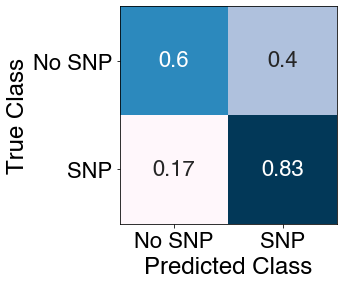

In [67]:
conf_mat = confusion_matrix(y_test, y_pred_rf, normalize='true', labels=[0, 1])

_, ax = plt.subplots()
sns.heatmap(
    conf_mat,
    cmap="PuBu",
    annot=True,
    annot_kws={'fontsize': 22},
    cbar=False,
    square=True,
    xticklabels=['No SNP', 'SNP'],
    yticklabels=['No SNP', 'SNP']
)
ax.tick_params(axis='both', labelsize=22)
ax.tick_params(axis='y', rotation=0)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
plt.xlabel('Predicted Class', fontsize=24)
plt.ylabel('True Class', fontsize=24)
plt.savefig(Path(FIG_PATH, 'confusion_matrix.svg'))
plt.show()

## Feature Importance

Let's identify the important features that each of our models are pulling out

#### Logistic Regression

In [69]:
coefs = fin_rf.feature_importances_

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13295bcd0>]],
      dtype=object)

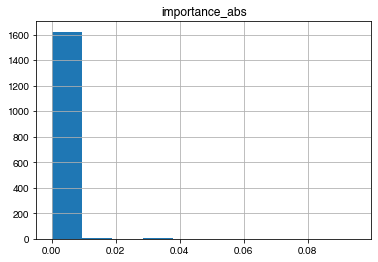

In [71]:
lr_feat_import_df = pd.DataFrame(
    data={
        'feature': bitome.matrix_row_labels,
        'importance': coefs.flatten(),
        'importance_abs': np.abs(coefs.flatten())
    }
).sort_values(by='importance_abs', ascending=False)

lr_feat_import_df.hist('importance_abs')

In [77]:
lr_feat_import_df[lr_feat_import_df['importance_abs'] > 0.0075]

,feature,importance,importance_abs
7,base_G_(-1),0.095105,0.095105
2,base_C_(+1),0.079505,0.079505
1,base_T_(+1),0.049753,0.049753
6,base_C_(-1),0.038427,0.038427
5,base_T_(-1),0.037561,0.037561
4,base_A_(-1),0.037275,0.037275
1633,mRNA_structure,0.032254,0.032254
3,base_G_(+1),0.027839,0.027839
770,TU_(-1),0.019422,0.019422
0,base_A_(+1),0.016961,0.016961
